In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Flatten, Reshape, Conv1D, Conv1DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from scipy.optimize import minimize
from sklearn.metrics import classification_report
from itertools import chain
import os

# Load Real Data

In [2]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt", header=None).values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt", header=None).values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt", header=None).values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [3]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])


HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

In [4]:
# SMOOTHING
BP_data_scaled_averaged = BP_data_scaled.rolling(64).mean()
HR_data_scaled_averaged = HR_data_scaled.rolling(64).mean()

# Loading Model

In [5]:
model = load_model("GRU_RESULTS_TRIMMED40_AVERAGED64\ACC66_VALACC64_RL2_C16_N10_E10_BS128_LR0.0005/model/")

# Labeling Validation Samples

In [20]:
indexes = ['375', '1', '92', '110', '158', '286', '295', '393', '460', '501', '606', '658', '675'] #375 is the longest, that's why it is in the beginning
# indexes = ['375', '393']

In [7]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

BP_HR_validation_labels = dict()
BP_validation = dict()
HR_validation = dict()
for index in indexes:
    BPx = np.array(BP_data_scaled_averaged[index])
    HRx = np.array(HR_data_scaled_averaged[index])
    BPx = BPx[~np.isnan(BPx)]
    HRx = HRx[~np.isnan(HRx)]
    BPx = BPx[:-(BPx.shape[0] % 32)]
    HRx = HRx[:-(HRx.shape[0] % 32)]
    BPxs = np.array(np.array_split(BPx, int(len(BPx)/32)))
    HRxs = np.array(np.array_split(HRx, int(len(HRx)/32)))
    BP_HR_validation_labels[index] = np.array(['g']*len(BPxs))
    BP_validation[index] = BPxs
    HR_validation[index]= HRxs

In [8]:
index = '1'
label_func('1', 80, 81, 'r')
label_func('1', 81, 107, 'r')
label_func('1', 107, 108, 'r')
index = '92' 
label_func('92', 41, 49, 'r')
label_func('92', 142, 143, 'r')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'r')
label_func('110', 120, 123, 'r')
index = '158' 
label_func('158', 25, 29, 'r')
label_func('158', 115, 116, 'r')
label_func('158', 116, 122, 'r')
label_func('158', 122, 123, 'r')
index = '286' 
label_func('286', 63, 65, 'r')
label_func('286', 65, 67, 'r')
label_func('286', 123, 124, 'r')
label_func('286', 124, 129, 'r')
label_func('286', 129, 131, 'r')
label_func('286', 131, 134, 'r')
index = '295' 
label_func('295', 131, 134, 'r')
label_func('295', 134, 144, 'r')
index = '375'
label_func('375', 40, 47, 'r')
label_func('375', 129, 133, 'r')
label_func('375', 133, 141, 'r')
label_func('375', 141, 144, 'r')
label_func('375', 162, 167, 'r')
index = '393' 
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'r')
index = '460' 
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'r')
index = '501'
label_func('501', 119, 120, 'r')
label_func('501', 120, 124, 'r')
label_func('501', 124, 125, 'r')
index = '606'
label_func('606', 60, 61, 'r')
label_func('606', 61, 70, 'r')
label_func('606', 70, 72, 'r')
index = '658', 
label_func('658', 36, 53, 'r')
label_func('658', 53, 55, 'r')
index ='675', 
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'r')

# Auxiliary Functions

In [9]:
BEST_MODEL_GRID_SEARCH_RESULTS_FILE_NAME = "BASELINE_GRU_best_model_thresholds_grid_search.tsv"

def series_to_supervised(share_prices, timestamps, input_time_steps, dropnan=True):
    share_prices_df = pd.DataFrame(share_prices)
    timestamps_df = pd.DataFrame(timestamps)
    share_prices_timeseries = list()
    timestamps_timeseries = list()
    
    for i in range(input_time_steps-1, -1, -1):
        share_prices_timeseries.append(share_prices_df.shift(i))
        timestamps_timeseries.append(timestamps_df.shift(i))
    
    aggregated_share_prices = pd.concat(share_prices_timeseries, axis=1)
    aggregated_timestamps = pd.concat(timestamps_timeseries, axis=1)
    
    if dropnan:
        aggregated_share_prices.dropna(inplace=True)
        aggregated_timestamps.dropna(inplace=True)

    aggregated_timestamps = aggregated_timestamps.values
    aggregated_share_prices = aggregated_share_prices.values
    
    not_overlapping_indexes = range(0, 
                                    len(aggregated_share_prices), 
                                    input_time_steps)
    
    aggregated_timestamps = aggregated_timestamps[not_overlapping_indexes]
    aggregated_share_prices = aggregated_share_prices[not_overlapping_indexes]
    return aggregated_share_prices, aggregated_timestamps
 

def split(BP_data, HR_data, col, time_steps):
    X = []
    y = []

    BP_supervised, HR_supervised = series_to_supervised(BP_data[col], HR_data[col], time_steps)
    for BP_interval, HR_interval in zip(BP_supervised, HR_supervised):
        BP_HR_interval = []
        for BP_time_step, HR_time_step in zip(BP_interval, HR_interval):
            BP_HR_interval.append([BP_time_step, HR_time_step])
        X.append(BP_HR_interval)
        if labels[col] == 'Synkope': label = [0., 1.] 
        else: label = [1., 0.]
        y.append(label)
    return np.array(X), np.array(y)

def sample_timeseries(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if x.shape[0] % 32 != 0:
        x = x[:-(x.shape[0] % 32)]
    return np.array(np.array_split(x, int(len(x)/32)))

N_SAMPLES_MEMORY = 5
BP_HR_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)
def zero_accumulators():
    global BP_HR_SEVERITY_ACC
    BP_HR_SEVERITY_ACC = np.zeros(N_SAMPLES_MEMORY)

def classifier(y_pred, a, b):
    global BP_HR_SEVERITY_ACC
    BP_HR_anomaly_score = y_pred[-1][1]
    BP_HR_SEVERITY_ACC = np.append(BP_HR_SEVERITY_ACC, BP_HR_anomaly_score)
    if BP_HR_anomaly_score > a or np.mean(BP_HR_SEVERITY_ACC[-5:]) > b:
        return 'r'
    else:
        return 'g'

def write_to_file(path, header, *args):
    with open(path, 'a') as file:
        if os.stat(path).st_size == 0:
            file.write(header)
        text = str()
        for item in args:
            text += str(item) + '\t'
        file.write('\n' + text)

def count_samples(timeseries):
    n_of_not_nans = np.count_nonzero(~np.isnan(timeseries))
    return int(n_of_not_nans/32)

def calculate_metrics(direct_threshold, average_threshold, labels_true, labels_pred, write_file):
    class_report = classification_report(labels_true, labels_pred, output_dict=True)
    acc = round(class_report['accuracy'], 4)
    red_f1 = round(class_report['r']['f1-score'], 4)
    red_precision = round(class_report['r']['precision'], 4)
    red_recall = round(class_report['r']['recall'], 4)
    green_f1 = round(class_report['g']['f1-score'], 4)
    green_precision = round(class_report['g']['precision'], 4)
    green_recall = round(class_report['g']['recall'], 4)
    if write_file:
        write_to_file(BEST_MODEL_GRID_SEARCH_RESULTS_FILE_NAME, 
                      "Direct Threshold\tAveraged Threshold\tAccuracy\tRed F1\tRed Precision\tRed Recall\tGreen F1\tGreen Precision\tGreen Recall",
                      direct_threshold,
                      average_threshold,
                      acc,
                      red_f1,
                      red_precision,
                      red_recall,
                      green_f1,
                      green_precision,
                      green_recall)  
    return red_f1

def evaluate_model(y_pred, direct_threshold, average_threshold, write_file):
    start = time()
    labels_pred = np.array([])
    
    for i in indexes:
        zero_accumulators()
        n_of_samples_in_timeseries = count_samples(BP_data_scaled_averaged[i])
        for j in range(n_of_samples_in_timeseries):   
            severity = classifier(y_pred[i][:j+1], direct_threshold, average_threshold)
            labels_pred = np.append(labels_pred, severity)
    labels_true = np.array(list(chain(*BP_HR_validation_labels.values())), dtype=str)  
    example_metric = calculate_metrics(direct_threshold, average_threshold, labels_true, labels_pred, write_file)
    
#     print(f"Red F1: {example_metric:.4f}, DT: {direct_threshold:.3f}, AT: {average_threshold:.3f}, time:{(time() - start):.2f}s")

# Parameters Optimization

In [10]:
direct_thresholds = np.array(range(100, 910, 10)) / 1000
average_thresholds = np.array(range(100, 910, 10)) / 1000
print(direct_thresholds)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 ]


In [11]:
 def calc_predicted_values(BP_data, HR_data):
    y_pred = dict()
    for i in indexes:
        X_val, _ = split(BP_data, HR_data, i, 32)
        y_pred[i] = model.predict(X_val)   
    return y_pred

def grid_search(direct_thresholds, average_thresholds, write_file=False):
    print("Calculating predictions ...")
    y_pred = calc_predicted_values(BP_data_scaled_averaged, HR_data_scaled_averaged)
    print("Calculating predictions done.")
    for direct_threshold in direct_thresholds:
        for average_threshold in average_thresholds:
            evaluate_model(y_pred, direct_threshold, average_threshold, write_file)

# grid_search(direct_thresholds, average_thresholds, True)

# Plotting Metrics

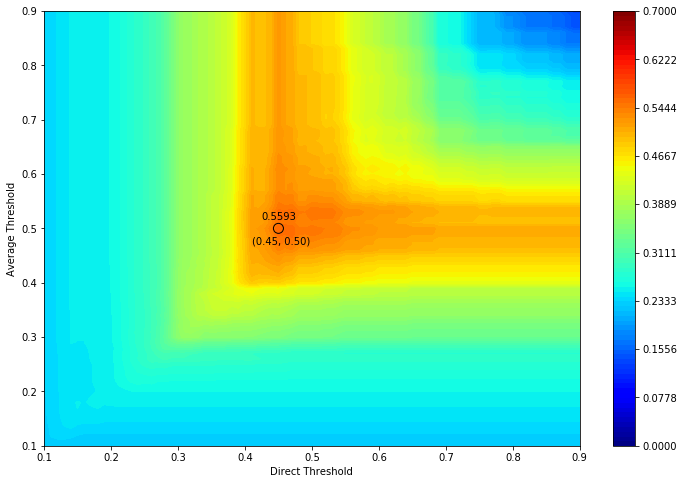

In [12]:
def plot_metric(AA, BB, CC):
    def f(AA, BB):
        C = np.zeros((len(AA), len(BB)))
        for i in range(len(AA)):
            for j in range(len(BB)):
                C[i, j] = CC[(AA[i], BB[j])]
        return C    
    A, B = np.meshgrid(AA, BB)
    C = f(AA, BB)
        
    max_val = np.max(C)
    x, y = np.where(C == max_val)
    max_val_x = A[x[0], x[0]]
    max_val_y = B[y[0], y[0]]
    
    fig, ax = plt.subplots(figsize=(12,8))
    levels = np.linspace(0, 0.7, 91)
    plt.contourf(A, B, C, levels=levels, cmap='jet')
    ax.set_xlabel('Average Threshold')
    ax.set_ylabel('Direct Threshold')
    plt.colorbar()
    ax.scatter([max_val_y], [max_val_x], marker='o', facecolors='none', s=100, edgecolors='black')
    ax.annotate(max_val, (max_val_y - 0.025, max_val_x + 0.015))
    ax.annotate(f'({max_val_y}, {max_val_x:.2f})', (max_val_y - 0.04, max_val_x - 0.03))
    plt.savefig('GRU_network_heatmap_F1.png')
    
    
def load_metric_and_plot(file_path, metric_name):
    metrics = pd.read_csv(file_path, delimiter='\t', index_col=False)
    direct_thresholds = sorted(metrics['Direct Threshold'].unique())
    average_thresholds = sorted(metrics['Averaged Threshold'].unique())
    selected_metric = dict()
    for index, row in metrics.iterrows():
        selected_metric[(round(row['Direct Threshold'], 2), round(row['Averaged Threshold'], 2))] = row[metric_name]
    plot_metric(direct_thresholds, average_thresholds, selected_metric)

load_metric_and_plot(BEST_MODEL_GRID_SEARCH_RESULTS_FILE_NAME, "Red F1")

# Save Timeseries Classification

In [13]:
y_pred = calc_predicted_values(BP_data_scaled_averaged, HR_data_scaled_averaged)

In [21]:
grid_search_results = pd.read_csv(BEST_MODEL_GRID_SEARCH_RESULTS_FILE_NAME, delimiter='\t', index_col=False)
best_parameters = grid_search_results.loc[grid_search_results['Red F1'] == max(grid_search_results['Red F1'])]
direct_threshold = best_parameters['Direct Threshold'].iloc[0]
average_threshold = best_parameters['Averaged Threshold'].iloc[0]
print(f"Chosen direct threshold: {direct_threshold}\nChosen average threshold: {average_threshold}")

predicted_labels = pd.DataFrame()
counter = 0
for i in indexes:
    counter = counter + 1
    labels = [] 
    zero_accumulators()
    HR = sample_timeseries(HR_data_scaled_averaged[i])
    BP = sample_timeseries(BP_data_scaled_averaged[i])
    n_of_samples = len(BP)
    for j in range(n_of_samples):
        labels.append(classifier(y_pred[i][:j+1], direct_threshold, average_threshold))
    predicted_labels[i] = pd.Series(labels)
    
predicted_labels.to_csv('best_model_best_params_predicted_labels.tsv', sep='\t')

Chosen direct threshold: 0.5
Chosen average threshold: 0.45


In [35]:
for i in thresholds:
    acc = classification_reports[i]['accuracy']
    red_f1 = classification_reports[i]['r']['f1-score']
    green_f1 = classification_reports[i]['g']['f1-score']
    print(f"Accuracy: {acc:.4f}, Green F1: {green_f1:.4f}, Red F1: {red_f1:.4f}, threshold: {i:.1f}")

Accuracy: 0.1399, Green F1: 0.0000, Red F1: 0.2454, threshold: 0.1
Accuracy: 0.2112, Green F1: 0.1579, Red F1: 0.2581, threshold: 0.2
Accuracy: 0.3362, Green F1: 0.3904, Red F1: 0.2716, threshold: 0.3
Accuracy: 0.6046, Green F1: 0.7237, Red F1: 0.3050, threshold: 0.4
Accuracy: 0.7740, Green F1: 0.8614, Red F1: 0.3891, threshold: 0.5
Accuracy: 0.8440, Green F1: 0.9096, Red F1: 0.4314, threshold: 0.6
Accuracy: 0.8904, Green F1: 0.9389, Red F1: 0.4691, threshold: 0.7
Accuracy: 0.8897, Green F1: 0.9396, Red F1: 0.3692, threshold: 0.8
Accuracy: 0.8716, Green F1: 0.9305, Red F1: 0.1511, threshold: 0.9


<IPython.core.display.Javascript object>


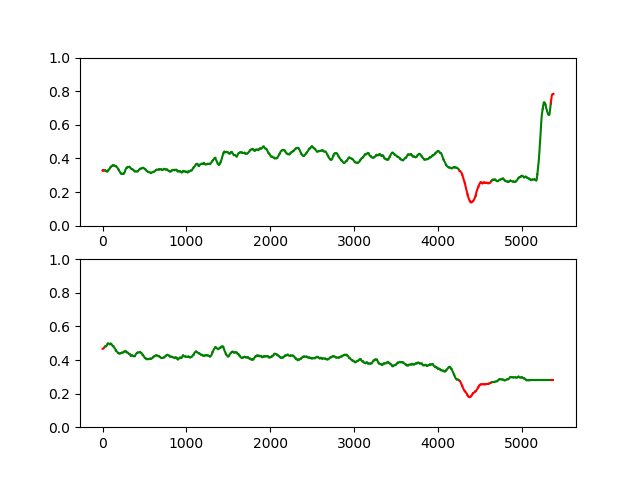

In [60]:
%matplotlib notebook
plt.ion()

n = '375'
HR = sample_timeseries(HR_data_scaled_averaged[n])
BP = sample_timeseries(BP_data_scaled_averaged[n])

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.set_ylim(0,1)
ax2 = fig1.add_subplot(212)
ax2.set_ylim(0,1)

t = 0
BP_last_elem = None
for HRv, BPv in zip(HR, BP):
    if BP_last_elem == None:
        
        HR_BP_samples = []
        for HR_sample, BP_sample in zip(HRv, BPv):
            HR_BP_samples.append([HR_sample, BP_sample])
        pred_values = model.predict(np.expand_dims(HR_BP_samples, axis=0))
        c = ['r' if y[1] > 0.5 else 'g' for y in pred_values][0]

        ax1.plot(range(t, t + len(HRv)), HRv, color=f'{c}', linestyle='-')
        ax2.plot(range(t, t + len(BPv)), BPv, color=f'{c}', linestyle='-')

        t += len(BPv)
    else:
        a = 5
        HR_BP_samples = []
        for HR_sample, BP_sample in zip(HRv, BPv):
            HR_BP_samples.append([HR_sample, BP_sample])
        pred_values = model.predict(np.expand_dims(HR_BP_samples, axis=0))
        c = ['r' if y[1] > 0.68 else 'g' for y in pred_values][0]

        time_range = range(t-1, t + len(BPv)) 
        BPv = np.concatenate(([BP_last_elem], BPv))
        HRv = np.concatenate(([HR_last_elem], HRv))
        ax1.plot(time_range, HRv, color=f'{c}', linestyle='-')
        ax2.plot(time_range, BPv, color=f'{c}', linestyle='-')

        t += len(BPv) - 1
    fig1.canvas.draw()
    BP_last_elem = BPv[-1]
    HR_last_elem = HRv[-1] 